In [6]:
# ----------- Imports -----------
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import tensorflow  # For future ML use
import sklearn     # For preprocessing & modeling

# ----------- Load Dataset -----------
df = pd.read_csv(r"C:\Users\mvenk\Downloads\products.csv")

In [7]:

# ----------- Initial Exploration -----------
print(df.shape)        # Rows x Columns
print(df.head())       # First 5 rows
print(df.tail())       # Last 5 rows
print(df.describe())   # Stats summary
print(df.info())       # Column info
print(df.columns)      # Column names


(10000, 14)
  Product ID Product Name Product Category Product Description   Price  \
0   93TGNAY7       Laptop  Home Appliances       Product_XU5QX  253.17   
1   TYYZ5AV7   Smartphone         Clothing       Product_NRUMS  214.37   
2   5C94FGTQ   Headphones         Clothing       Product_IT7HG  475.29   
3   XBHKYPQB      Monitor         Clothing       Product_8SBDO  403.33   
4   728GCZFU       Laptop  Home Appliances       Product_54FAF  229.81   

   Stock Quantity  Warranty Period Product Dimensions Manufacturing Date  \
0               3                2        16x15x15 cm         2023-01-01   
1              92                2        15x19x19 cm         2023-03-15   
2              19                2           9x6x6 cm         2023-03-15   
3              40                1          7x13x5 cm         2023-01-01   
4              32                2        20x20x19 cm         2023-07-30   

  Expiration Date     SKU Product Tags Color/Size Variations  Product Ratings  
0     

In [8]:
# ----------- Date Conversion -----------
df['Manufacturing Date'] = pd.to_datetime(df["Manufacturing Date"], errors='coerce')
df['Expiration Date'] = pd.to_datetime(df["Expiration Date"], errors='coerce')


In [9]:
# ----------- Create New Columns from Dates -----------
df['Shelf_Life_Days'] = (df['Expiration Date'] - df["Manufacturing Date"]).dt.days

In [10]:
# ----------- Clean Column Names -----------
df.columns = df.columns.str.strip().str.replace(" ", "_")

In [11]:
# ----------- Check Duplicates -----------
duplicates = df.duplicated().sum()
print("Duplicate rows:", duplicates)


Duplicate rows: 0


In [12]:

# ----------- Data Type Conversion -----------
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Stock_Quantity'] = pd.to_numeric(df['Stock_Quantity'], errors='coerce')
df['Product_Ratings'] = pd.to_numeric(df['Product_Ratings'], errors='coerce')

In [13]:

# ----------- Redundant Re-conversion (Safety Check) -----------
df['Manufacturing_Date'] = pd.to_datetime(df["Manufacturing_Date"], errors='coerce')
df["Expiration_Date"] = pd.to_datetime(df["Expiration_Date"], errors='coerce')


In [14]:
# ----------- Convert Specified Categorical Columns to 'category' Type -----------
categorical_cols = ['Product_Name', 'Product_Category', 
                    'Product_Description', 'Product_Dimensions', 
                    'SKU', 'Product_Tags', 'Color/Size_Variations']
for col in categorical_cols:
    df[col] = df[col].astype('category')

In [15]:
# ----------- Check Updated Info -----------
print(df.info())
print(df[['Price', 'Stock_Quantity', 'Product_Ratings']].info())
print(df[['Price', 'Stock_Quantity', 'Product_Ratings']].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Product_ID             10000 non-null  object        
 1   Product_Name           10000 non-null  category      
 2   Product_Category       10000 non-null  category      
 3   Product_Description    10000 non-null  category      
 4   Price                  10000 non-null  float64       
 5   Stock_Quantity         10000 non-null  int64         
 6   Warranty_Period        10000 non-null  int64         
 7   Product_Dimensions     10000 non-null  category      
 8   Manufacturing_Date     10000 non-null  datetime64[ns]
 9   Expiration_Date        10000 non-null  datetime64[ns]
 10  SKU                    10000 non-null  category      
 11  Product_Tags           10000 non-null  category      
 12  Color/Size_Variations  10000 non-null  category      
 13  Pr

In [16]:
# ----------- Date-Derived Features -----------
df['Days_Until_Expiry'] = (df['Expiration_Date'] - pd.Timestamp.today()).dt.days
df['Product_Age_Days'] = (pd.Timestamp.today() - df['Manufacturing_Date']).dt.days


In [17]:
# ----------- Strip Whitespaces in Categorical Columns -----------
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.str.strip() if x.dtype == 'object' else x)


In [18]:
# ----------- Handle Missing Values -----------
print(df.isnull().sum())
# Use one of the below lines based on needs:
# df.dropna(inplace=True)           # Remove rows with nulls
# df.fillna(method='ffill', inplace=True)  # Forward fill as example

# ----------- Encode Categorical Variables -----------
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
for col in categorical_cols:
    if df[col].nunique() <= 2: 
        df[col] = label_enc.fit_transform(df[col])  # Binary columns only

Product_ID               0
Product_Name             0
Product_Category         0
Product_Description      0
Price                    0
Stock_Quantity           0
Warranty_Period          0
Product_Dimensions       0
Manufacturing_Date       0
Expiration_Date          0
SKU                      0
Product_Tags             0
Color/Size_Variations    0
Product_Ratings          0
Shelf_Life_Days          0
Days_Until_Expiry        0
Product_Age_Days         0
dtype: int64


In [19]:
# ----------- Sum of Stock Quantity per Price -----------
sum_stock = df.groupby('Price')['Stock_Quantity'].sum().sort_values(ascending=False)
print("Stock Quantity by Price:\n", sum_stock)

Stock Quantity by Price:
 Price
75.16     272
343.92    261
367.79    256
413.24    245
11.02     242
         ... 
96.46       1
386.46      1
384.04      1
32.76       1
54.02       1
Name: Stock_Quantity, Length: 9036, dtype: int64


In [20]:
unique_products = df.groupby("Price")['Product_ID'].nunique()
print("Unique Products per Price:\n", unique_products)

Unique Products per Price:
 Price
10.22     1
10.25     1
10.27     1
10.32     1
10.36     1
         ..
499.74    1
499.77    2
499.84    1
499.86    1
499.97    1
Name: Product_ID, Length: 9036, dtype: int64


In [21]:
# ----------- Save Original Product_Category for EDA Before Encoding -----------
df['Original_Product_Category'] = df['Product_Category']  # Save a copy for grouping later

# ----------- Limit to Low-Cardinality Categorical Columns -----------
categorical_cols = ['Product_Category', 'Color/Size_Variations']

# ----------- Reduce Infrequent Categories to 'Other' -----------
for col in categorical_cols:
    top_vals = df[col].value_counts().nlargest(10).index
    df[col] = df[col].apply(lambda x: x if x in top_vals else 'Other')

# ----------- Encode Categorical Variables (LabelEncoder + OneHotEncoding) -----------
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()

# Apply Label Encoding if binary
for col in categorical_cols:
    if df[col].nunique() <= 2:
        df[col] = label_enc.fit_transform(df[col])

# Apply One-Hot Encoding for rest
df = pd.get_dummies(df, columns=[col for col in categorical_cols if df[col].nunique() > 2], drop_first=True)

# ----------- EDA: Category-Level Aggregation -----------
category_agg = df.groupby("Original_Product_Category").agg({
    'Price': ['mean', 'min', 'max'],
    'Stock_Quantity': 'sum',
    'Product_Ratings': 'mean',
    'Shelf_Life_Days': 'mean',
    'Days_Until_Expiry': 'mean',
    'Product_Age_Days': 'mean'
}).round(2)

print("Category-wise Aggregation:")
print(category_agg)



Category-wise Aggregation:
                            Price                Stock_Quantity  \
                             mean    min     max            sum   
Original_Product_Category                                         
Clothing                   251.79  10.25  499.97         169548   
Electronics                253.43  10.22  499.77         170705   
Home Appliances            258.84  10.27  499.71         166218   

                          Product_Ratings Shelf_Life_Days Days_Until_Expiry  \
                                     mean            mean              mean   
Original_Product_Category                                                     
Clothing                             3.02          644.14            -94.41   
Electronics                          2.98          638.69            -99.66   
Home Appliances                      3.01          636.33            -99.22   

                          Product_Age_Days  
                                      mean  
Origi

C:\Users\mvenk\AppData\Local\Temp\ipykernel_16740\1051194607.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_agg = df.groupby("Original_Product_Category").agg({


In [22]:
# ----------- Average Ratings by a Dummy Column (Example) -----------`
# NOTE: Replace with a valid one-hot column name that exists in your df
example_col = [col for col in df.columns if 'Color/Size_Variations' in col]
if example_col:
    avg_rating = df.groupby(example_col[0])['Product_Ratings'].mean().sort_values(ascending=False)
    print("Avg Ratings by", example_col[0], ":\n", avg_rating.head(10))

Avg Ratings by Color/Size_Variations_Green/Large :
 Color/Size_Variations_Green/Large
False    3.012381
True     2.989078
Name: Product_Ratings, dtype: float64


In [23]:
# ----------- Final Check -----------
print("Final Shape:", df.shape)
print(df.columns)

Final Shape: (10000, 20)
Index(['Product_ID', 'Product_Name', 'Product_Description', 'Price',
       'Stock_Quantity', 'Warranty_Period', 'Product_Dimensions',
       'Manufacturing_Date', 'Expiration_Date', 'SKU', 'Product_Tags',
       'Product_Ratings', 'Shelf_Life_Days', 'Days_Until_Expiry',
       'Product_Age_Days', 'Original_Product_Category',
       'Product_Category_Electronics', 'Product_Category_Home Appliances',
       'Color/Size_Variations_Green/Large', 'Color/Size_Variations_Red/Small'],
      dtype='object')


In [24]:
df.shape

(10000, 20)

In [25]:
category_agg.sort_values(('Price', 'mean'), ascending=False, inplace=True)


In [26]:
df.to_csv(r"E:\cleanes.csv", index=False)

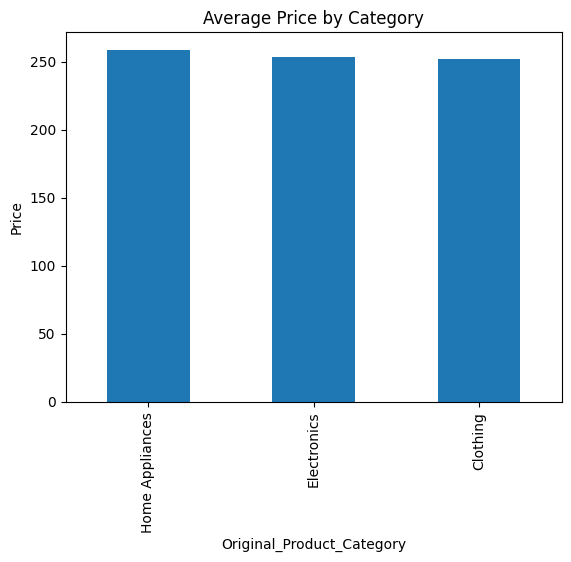

In [27]:
category_agg['Price']['mean'].plot(kind='bar', title='Average Price by Category')
plt.ylabel("Price")
plt.show()


4.multiple aggregations 

In [29]:
df.columns

Index(['Product_ID', 'Product_Name', 'Product_Description', 'Price',
       'Stock_Quantity', 'Warranty_Period', 'Product_Dimensions',
       'Manufacturing_Date', 'Expiration_Date', 'SKU', 'Product_Tags',
       'Product_Ratings', 'Shelf_Life_Days', 'Days_Until_Expiry',
       'Product_Age_Days', 'Original_Product_Category',
       'Product_Category_Electronics', 'Product_Category_Home Appliances',
       'Color/Size_Variations_Green/Large', 'Color/Size_Variations_Red/Small'],
      dtype='object')

In [30]:
category_agg = df.groupby('Original_Product_Category').agg({
    'Price': ['mean', 'min', 'max'],
    'Stock_Quantity': 'sum',
    'Product_Ratings': 'mean'
})
print(category_agg)


                                Price                Stock_Quantity  \
                                 mean    min     max            sum   
Original_Product_Category                                             
Clothing                   251.790928  10.25  499.97         169548   
Electronics                253.427581  10.22  499.77         170705   
Home Appliances            258.839770  10.27  499.71         166218   

                          Product_Ratings  
                                     mean  
Original_Product_Category                  
Clothing                         3.017959  
Electronics                      2.982148  
Home Appliances                  3.014251  


C:\Users\mvenk\AppData\Local\Temp\ipykernel_16740\1597718663.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_agg = df.groupby('Original_Product_Category').agg({


In [31]:
# histogram Price ditribution

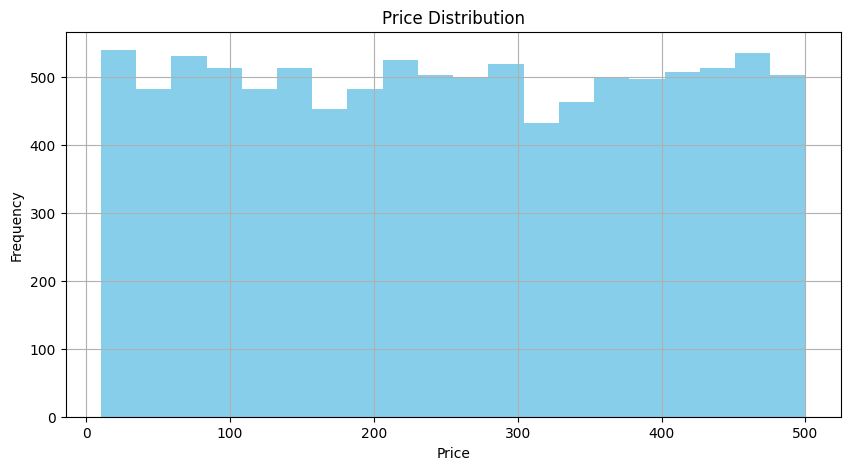

In [32]:
df['Price'].plot(kind = 'hist',bins = 20,figsize=(10,5),title = "Price Distribution",color='skyblue')
plt.xlabel("Price")
plt.grid(True)
plt.show()

In [33]:
df.columns

Index(['Product_ID', 'Product_Name', 'Product_Description', 'Price',
       'Stock_Quantity', 'Warranty_Period', 'Product_Dimensions',
       'Manufacturing_Date', 'Expiration_Date', 'SKU', 'Product_Tags',
       'Product_Ratings', 'Shelf_Life_Days', 'Days_Until_Expiry',
       'Product_Age_Days', 'Original_Product_Category',
       'Product_Category_Electronics', 'Product_Category_Home Appliances',
       'Color/Size_Variations_Green/Large', 'Color/Size_Variations_Red/Small'],
      dtype='object')

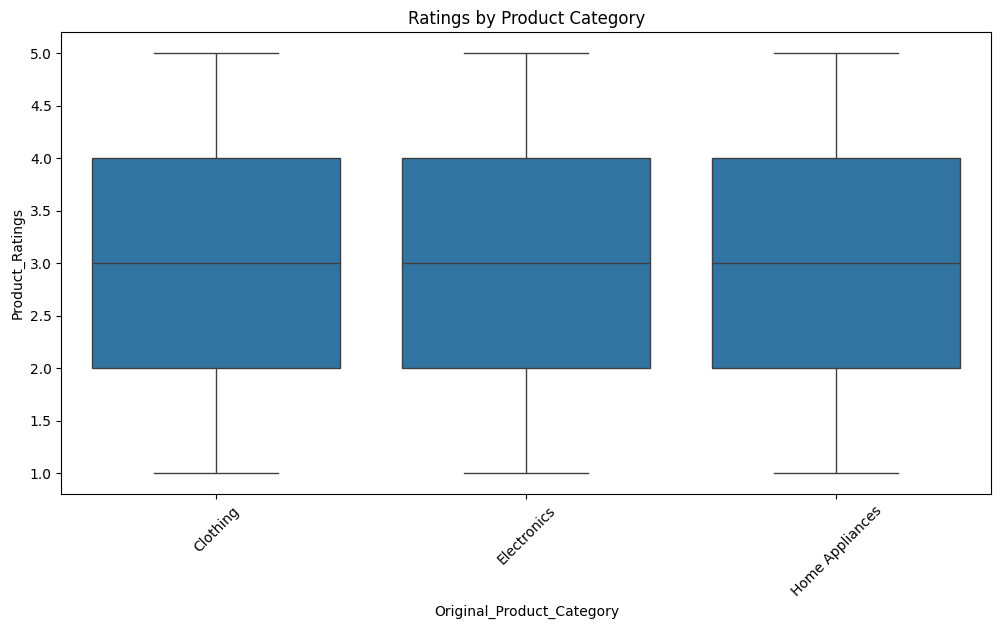

In [34]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Original_Product_Category', y='Product_Ratings', data=df)
plt.xticks(rotation=45)
plt.title("Ratings by Product Category")
plt.show()


In [ ]:
sum_stock.plot(kind='bar', figsize=(12,6), color='teal')
plt.title("Total Stock per Product Category")
plt.ylabel("Stock Quantity")
plt.xticks(rotation=45)
plt.show()


# pair plot key metrics 

In [ ]:
sns.pairplot(df[['Price','Stock_Quantity','Product_Ratings']])
plt.suptitle('Pairwise Relationships',y=1.02)
plt.show()

# correlations Heatmap

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df[["Price","Stock_Quantity","Product_Ratings"]].corr(),annot=True,cmap= "coolwarm")
plt.title("Correlation Heatmap")
plt.show()

 # Time Series Plot – Products by Manufacturing Year

In [ ]:
df.columns

In [ ]:
df['Manufacturing Month'] = df['Manufacturing_Date'].dt.to_period('M')
monthly_trend = df.groupby('Manufacturing Month')['Price'].mean()

monthly_trend.plot(kind='line', marker='o', figsize=(12, 5), title="Average Price Trend Over Time")
plt.ylabel("Average Price")
plt.grid(True)
plt.show()


Univariate Analysis (Distribution) & Boxplots to Detect Outliers

In [ ]:
plt.figure(figsize=(10,5))
sns.boxenplot(df['Price'])
plt.title("Boxplot - Detect Outliers in Price")
plt.show()

bivariate releation ships

In [ ]:
sns.lmplot(x='Price', y='Product_Ratings', data=df, hue='Original_Product_Category', height=6, aspect=1.5)
plt.title("Linear Relationship: Price vs Rating by Category")
plt.show()


 Bar Plot for Grouped Summary (Avg Price, Stock, Ratings)

In [ ]:
category_group = df.groupby('Original_Product_Category')[['Price', 'Stock_Quantity', 'Product_Ratings']].mean().sort_values(by='Price', ascending=False)
category_group.plot(kind='bar', figsize=(12, 6))
plt.title("Average Price, Stock, and Rating per Product Category")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.show()
